In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate

In [ ]:
import json
import pandas as pd

with open('exact_matches.json','r') as f:
    exact = json.load(f)
with open('domain_matches.json','r') as f:
    domain = json.load(f)

rows = []
for news, cb in exact:
    rows.append({
        'match_type':  'exact',
        'news_id':     news.get('id'),
        'news_title':  news.get('title'),
        'news_url':    news.get('clean_url'),
        'click_id':    cb.get('id'),
        'click_title': cb.get('title'),
        'click_url':   cb.get('clean_url'),
    })

for news, cb in domain:
    rows.append({
        'match_type':  'domain',
        'news_id':     news.get('id'),
        'news_title':  news.get('title'),
        'news_url':    news.get('clean_url'),
        'click_id':    cb.get('id'),
        'click_title': cb.get('title'),
        'click_url':   cb.get('clean_url'),
    })

df_matches = pd.DataFrame(rows)

cols = [
    'match_type','similarity',
    'news_id','news_title','news_url',
    'click_id','click_title','click_url'
]
df_matches = df_matches.reindex(columns=[c for c in cols if c in df_matches.columns])

print(df_matches.shape, "rows × columns")
display(df_matches.head())

df_matches.to_csv('matched_pairs.csv', index=False)


(34823, 7) rows × columns


,match_type,news_id,news_title,news_url,click_id,click_title,click_url
0,exact,1gffymz,Inside Nigeria’s food delivery landscape: Chal...,,1jyvxdg,The abandoned London Underground station where...,
1,exact,1gfllr9,U.S. Economy Grew at 2.8% Rate in Third Quarter,,1jyvxdg,The abandoned London Underground station where...,
2,exact,1gfm8zr,Biden's 'garbage' remarks give Trump and GOP n...,,1jyvxdg,The abandoned London Underground station where...,
3,exact,1gfmjlp,Researchers tortured robots to test the limits...,,1jyvxdg,The abandoned London Underground station where...,
4,exact,1gfrqe4,Novedades Android 15 #android #google #rafaelm...,https://youtube.com/watch,1k9so8f,I used to think that love was enough but | ju...,https://youtube.com/watch


In [ ]:
import json
import re
from urllib.parse import urlparse
import pandas as pd

records = []
with open('r_savedyouaclick_posts.jsonl') as f:
    for line in f:
        records.append(json.loads(line))
df = pd.DataFrame(records)

def extract_original_url(url):
    p = urlparse(url)
    if 'web.archive.org' in p.netloc:
        m = re.match(r'/web/\d+/(https?://.+)', p.path)
        if m:
            return m.group(1)
    return url

traditional_regex = re.compile(
    r"(?:bbc\.com|reuters\.com|cnn\.com|"
    r"nbcnews\.com|apnews\.com|theguardian\.com|"
    r"nytimes\.com|washingtonpost\.com|wsj\.com|"
    r"cbsnews\.com|abcnews\.go\.com|npr\.org)"
)
digital_regex = re.compile(
    r"(?:buzzfeed\.com|huffpost\.com|dailymail\.co\.uk|"
    r"allrecipes\.com|gobankingrates\.com|parade\.com|"
    r"screenrant\.com|cnbc\.com|forbes\.com|msn\.com|yahoo\.com)"
)

def get_publisher_type(raw_url):
    orig = extract_original_url(raw_url)
    dom = urlparse(orig).netloc.lower()
    if traditional_regex.search(dom):
        return 'traditional'
    if digital_regex.search(dom):
        return 'digital-native'
    return 'other'

df['publisher_type'] = df['url'].apply(get_publisher_type)

print(df['publisher_type'].value_counts())
print(df.groupby('publisher_type')['url'].agg(lambda urls: sorted({urlparse(extract_original_url(u)).netloc.lower() for u in urls})))

publisher_type
other             307
digital-native     34
traditional        10
Name: count, dtype: int64
publisher_type
digital-native    [finance.yahoo.com, parade.com, screenrant.com...
other             [, archive.fo, archive.is, archive.ph, archive...
traditional       [edition.cnn.com, www.bbc.com, www.cbsnews.com...
Name: url, dtype: object


<Axes: xlabel='publisher_type'>

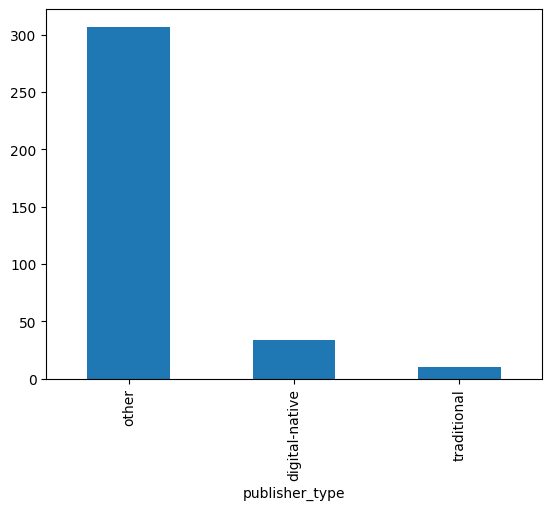

In [19]:
df['publisher_type'].value_counts().plot(kind='bar')


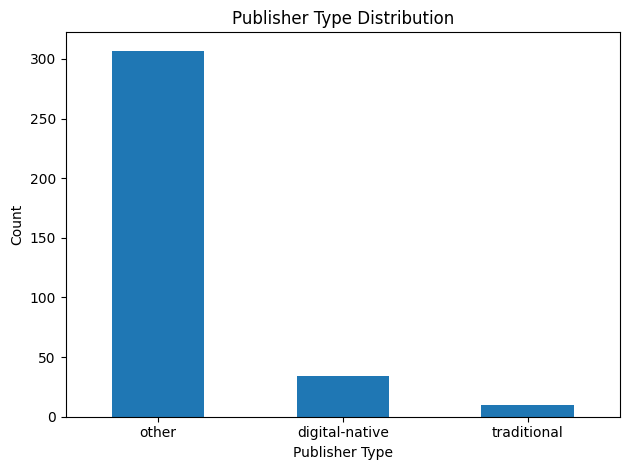

In [ ]:
import matplotlib.pyplot as plt

df['publisher_type'].value_counts().plot(kind='bar', rot=0)
plt.title("Publisher Type Distribution")
plt.xlabel("Publisher Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

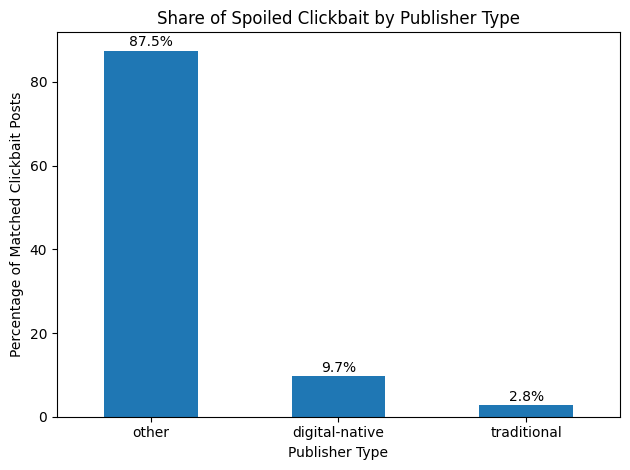

In [ ]:
import matplotlib.pyplot as plt

counts = df['publisher_type'].value_counts(normalize=True)*100
counts.plot(kind='bar', rot=0)
plt.title("Share of Spoiled Clickbait by Publisher Type")
plt.ylabel("Percentage of Matched Clickbait Posts")
plt.xlabel("Publisher Type")
for i,v in enumerate(counts):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()

In [ ]:
import re
def spoiler_type(txt):
    if re.search(r'\b1\.', txt):      return 'multi'
    if len(txt.split('.')) > 2:       return 'passage'
    return 'phrase'

df['spoiler_type'] = df['spoiler_text'].apply(spoiler_type)
print(df['spoiler_type'].value_counts())

spoiler_type
phrase     28577
passage     5643
multi        603
Name: count, dtype: int64


In [11]:
engagement = df.groupby('spoiler_type')[['score','num_comments']].mean()
engagement

,score,num_comments
spoiler_type,,
multi,93.000000,6.000000
passage,484.660110,38.119972
phrase,243.060153,12.588025


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# 1. Prepare your labeled dataset (as before)
click = pd.read_json('clickbait_posts.json')
news  = pd.read_json('news_posts.json')
click['label'] = 1
news['label']  = 0
df = pd.concat([ click[['title','label']], news[['title','label']] ], ignore_index=True)

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['title'], df['label'], stratify=df['label'], test_size=0.2, random_state=42
)

# 3. Build a TF-IDF + MultinomialNB pipeline
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
    ('clf',   MultinomialNB())
])

# 4. Train
pipe_nb.fit(X_train, y_train)

# 5. Predict on the r/news posts
news['pred_nb'] = pipe_nb.predict(news['title'])

# 6. List titles predicted as clickbait
clickbait_news_titles = news.loc[news['pred_nb'] == 1, 'title']
print("News titles predicted as clickbait by Naive Bayes:")
for t in clickbait_news_titles.tolist():
    print("–", t)


News titles predicted as clickbait by Naive Bayes:
– A letter written onboard the Titanic before it sank sells for almost $400,000 at auction
– Jack in the Box to close up to 200 restaurants, explore sale of Del Taco brand
– Virginia Giuffre, one of Jeffrey Epstein's most prominent abuse survivors, dies by suicide
– California’s economy surpasses Japan’s as it becomes fourth largest in world
– Feds accidentally publish secret plan to kill NYC congestion pricing
– German beer sales down at home and abroad
– Germany seeks to deport an American and 3 EU citizens after pro-Palestinian protest
– Video shows doctor with measles treating kids. RFK Jr later praised him as an ‘extraordinary’ healer
– Key regulators approve merger of Capital One and Discover, paving the way for a new biggest credit card company
– Astronomers Detect a Possible Signature of Life on a Distant Planet
– The State Department closes the office that flags disinformation from Russia, China and Iran
– Tuvalu unveils first